# Import MNIST Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


100%|██████████| 9912422/9912422 [00:00<00:00, 89523142.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24006280.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24605671.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4221256.10it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Inverse Images

In [2]:
trainset.data = 1 - trainset.data
testset.data = 1 - testset.data

# Make CNN Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        
net = Net()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [16]:
optimizerLoss = []

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        optimizerLoss.append(loss.detach().numpy())
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.106
[1,   400] loss: 0.112
[1,   600] loss: 0.103
[1,   800] loss: 0.110
[2,   200] loss: 0.102
[2,   400] loss: 0.102
[2,   600] loss: 0.107
[2,   800] loss: 0.102
[3,   200] loss: 0.102
[3,   400] loss: 0.106
[3,   600] loss: 0.100
[3,   800] loss: 0.101
[4,   200] loss: 0.097
[4,   400] loss: 0.099
[4,   600] loss: 0.100
[4,   800] loss: 0.099
[5,   200] loss: 0.091
[5,   400] loss: 0.086
[5,   600] loss: 0.093
[5,   800] loss: 0.095
[6,   200] loss: 0.091
[6,   400] loss: 0.096
[6,   600] loss: 0.085
[6,   800] loss: 0.096
[7,   200] loss: 0.087
[7,   400] loss: 0.093
[7,   600] loss: 0.085
[7,   800] loss: 0.091
[8,   200] loss: 0.088
[8,   400] loss: 0.077
[8,   600] loss: 0.091
[8,   800] loss: 0.087
[9,   200] loss: 0.088
[9,   400] loss: 0.083
[9,   600] loss: 0.081
[9,   800] loss: 0.081
[10,   200] loss: 0.083
[10,   400] loss: 0.082
[10,   600] loss: 0.084
[10,   800] loss: 0.084
Finished Training


# Accuracy

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the test images: 96 %


# Plot of Images

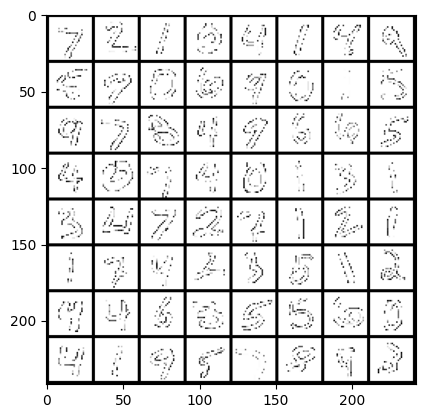

In [18]:
import matplotlib.pyplot as plt
import torchvision

# Get a batch of test images
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# Reverse the color of the images
reversed_images = 1 - images

# Show the images
img = torchvision.utils.make_grid(reversed_images)
plt.imshow(img.permute(1, 2, 0))
plt.show()
